Convergence detected at iteration: 96110 (iterations until convergence: 96099)


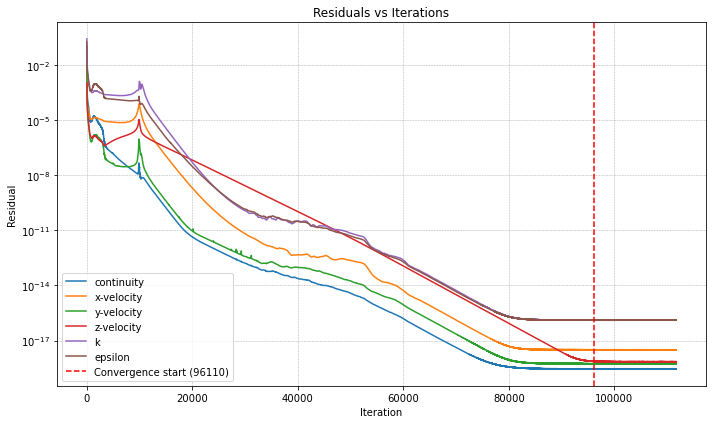

In [13]:
import re
import numpy as np
import matplotlib.pyplot as plt

def parse_iterations_from_trn(path):
    """Extracts iteration number and residuals from a Fluent .trn transcript file."""
    with open(path, "r", errors="ignore") as f:
        lines = f.read().splitlines()

    header_re = re.compile(r'^\s*iter\s+continuity', re.IGNORECASE)
    # Match: iter + 6 residual columns + ETA + iters_left
    data_re = re.compile(
        r'^\s*(\d+)\s+([-\deE\.+]+)\s+([-\deE\.+]+)\s+([-\deE\.+]+)\s+([-\deE\.+]+)\s+([-\deE\.+]+)\s+([-\deE\.+]+)\s+\S+\s+\d+\s*$'
    )

    iters = []
    resids = []
    in_table = False

    for line in lines:
        if header_re.search(line):
            in_table = True
            continue
        if in_table:
            m = data_re.match(line)
            if m:
                iters.append(int(m.group(1)))
                resids.append([float(m.group(i)) for i in range(2, 8)])
            elif line.strip() == "":
                in_table = False  # End of a block

    return np.array(iters), np.array(resids)

def find_convergence_iter(iters, resids, window=200, slope_tol=1e-5, min_iter=200):
    """Finds first iteration where all residual slopes are below slope_tol over a window."""
    log_res = np.log10(np.clip(resids, 1e-300, None))
    N = len(iters)

    for i in range(min_iter, N - window):
        x = np.arange(window)
        ok = True
        for j in range(log_res.shape[1]):
            slope = np.polyfit(x, log_res[i:i+window, j], 1)[0]
            if abs(slope) > slope_tol:
                ok = False
                break
        if ok:
            return iters[i]
    return None
sim_num=1
# === MAIN SCRIPT ===
trn_file = file_path = f"C:/Users/Sari Kardosh/OneDrive/Documents/GitHub/sari-data/trn/sim{sim_num} trn.trn"  # change to your file path

iters, resids = parse_iterations_from_trn(trn_file)
conv_iter = find_convergence_iter(iters, resids)

print(f"Convergence detected at iteration: {conv_iter} (iterations until convergence: {conv_iter - iters[0] + 1})")

# Plot residuals
plt.figure(figsize=(10,6))
for j, label in enumerate(["continuity", "x-velocity", "y-velocity", "z-velocity", "k", "epsilon"]):
    plt.semilogy(iters, resids[:, j], label=label)

if conv_iter:
    plt.axvline(conv_iter, color='r', linestyle='--', label=f'Convergence start ({conv_iter})')

plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.title("Residuals vs Iterations")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig(f'residuals plot simulation {sim_num}')
plt.show()

